# <div class="title_h1">Assignment 2</div>
## <div class="title_h2">Do the number of trees in a London borough affect GCSE results?</div>
### <div class="title_h3">Nic Young</div>

Data is sourced from...
* the [Greater London Authority list of maintained trees](https://data.london.gov.uk/dataset/local-authority-maintained-trees) (July 2021)
* the [Department of Eduction GCSE results](https://data.london.gov.uk/dataset/gcse-results-by-borough) (2015 - 2023)
* the [Greater London Authority figures for Land Area and Population Density, Ward and Borough](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough) 2011


GCSEs: There is a separate csv file for each academic year. We'll start with the 2020 - 2021 results since tree data is from 2021.

Trees: Each row represents a single tree planted in the city of London. There are 817,150 total records. The data set was last updated in July 2021.

Land area: Each row represnts one year, with figures or projects for housing density and land area. We are only interested in land area

## <div class="title_h2">Import common dependencies</div>

In [120]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

## <div class="title_h2">Land area</div>

### <div class="title_h3">Loading and cleaning the data</div>

In [121]:
# load the data
area_data_file = './data/housing-density-borough.csv'
area_raw = pd.read_csv(area_data_file)

area_raw.head(5)

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1


In [122]:
# select relevant data
borough_sizes = area_raw.drop_duplicates(subset=['Name', 'Square_Kilometres'])[['Name', 'Square_Kilometres']]

borough_sizes.head(100)

,Name,Square_Kilometres
0,City of London,2.9
52,Barking and Dagenham,36.1
104,Barnet,86.7
156,Bexley,60.6
208,Brent,43.2
260,Bromley,150.1
312,Camden,21.8
364,Croydon,86.5
416,Ealing,55.5
468,Enfield,80.8


## <div class="title_h2">GCSEs</div>

### <div class="title_h3">Data overview</div>

Available variables:
| variable                                                 | description                                                                            |
| -------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| `Code`                                                   | Borough area code.                                                                     |
| `Area`                                                   | Borough name.                                                                          |
| `Number of pupils at the end of key stage 4`             | The number of pupils included in the grade average.                                    |
| `Average Attainment 8 score per pupil`                   | Average GCSE score.                                                                    |
| `Percentage of pupils entered for components`            | English and maths GCSEs: Unsure. I am not familiar with the GCSE grading system.       |
| `Percentage of pupils who achieved a strong 9-5 pass`    | English and maths GCSEs: Percentage of pupils who attained a strong pass (above 5).    |
| `Percentage of pupils who achieved a standard 9-4 pass`  | English and maths GCSEs: Percentage of pupiles who attained a standard pass (above 4). |

These variables are individually available for all students, girls, and boys. We are interested in all students.

Unfortunately, the data is presented in an awkward format for the purpose of computational analysis. As such, I have made a copy of the 2020-21 data, in which I have manually removed the duplicated boys and girls sections, as they result in ambiguous named column indeces. The duplicated file we'll work from is called `./data/GCSE_results/2020-21_clean.csv`. It includes the above variables for all students only.

### <div class="title_h3">Loading and cleaning the data</div>

In [123]:
# load the data
gcses_data_file = './data/GCSE_results/2020-21_clean.csv'
gcses_raw = pd.read_csv(gcses_data_file)

gcses_raw.head(5)

,Code,Area,Number of pupils at the end of key stage 4,Average Attainment 8 score per pupil,Average Progress 8 score per pupil,Percentage of pupils entered for components,Percentage of pupils who achieved a strong 9-5 pass,Percentage of pupils who achieved a standard 9-4 pass
0,E09000002,Barking and Dagenham,2805,50.5,-,96.3,49.3,70.1
1,E09000003,Barnet,4100,60.8,-,97.5,69.8,84.0
2,E09000004,Bexley,3262,54.0,-,98.3,57.6,75.5
3,E09000005,Brent,3160,53.7,-,97.7,56.3,75.4
4,E09000006,Bromley,3356,55.2,-,97.3,59.5,78.8


In [124]:
# basic data
gcses_by_borough = gcses_raw[['Code', 'Area', 'Average Attainment 8 score per pupil']]

gcses_by_borough.head(50)

,Code,Area,Average Attainment 8 score per pupil
0,E09000002,Barking and Dagenham,50.5
1,E09000003,Barnet,60.8
2,E09000004,Bexley,54.0
3,E09000005,Brent,53.7
4,E09000006,Bromley,55.2
5,E09000007,Camden,53.1
6,E09000008,Croydon,50.0
7,E09000009,Ealing,53.6
8,E09000010,Enfield,51.1
9,E09000011,Greenwich,51.2


### <div class="title_h3">Exploratory analysis</div>

In [125]:
gcses_raw.describe()

,Number of pupils at the end of key stage 4,Average Attainment 8 score per pupil,Percentage of pupils entered for components,Percentage of pupils who achieved a strong 9-5 pass,Percentage of pupils who achieved a standard 9-4 pass
count,44.000000,44.000000,44.000000,44.000000,44.000000
mean,30068.590909,53.393182,97.020455,56.045455,74.963636
std,88412.927487,3.286151,0.835987,6.056726,4.505867
min,896.000000,49.100000,93.700000,48.300000,67.500000
25%,2337.750000,51.175000,96.800000,51.900000,71.400000
50%,3104.000000,52.950000,97.100000,54.550000,74.400000
75%,27514.000000,54.575000,97.525000,58.050000,76.225000
max,575863.000000,62.000000,98.300000,71.600000,84.800000


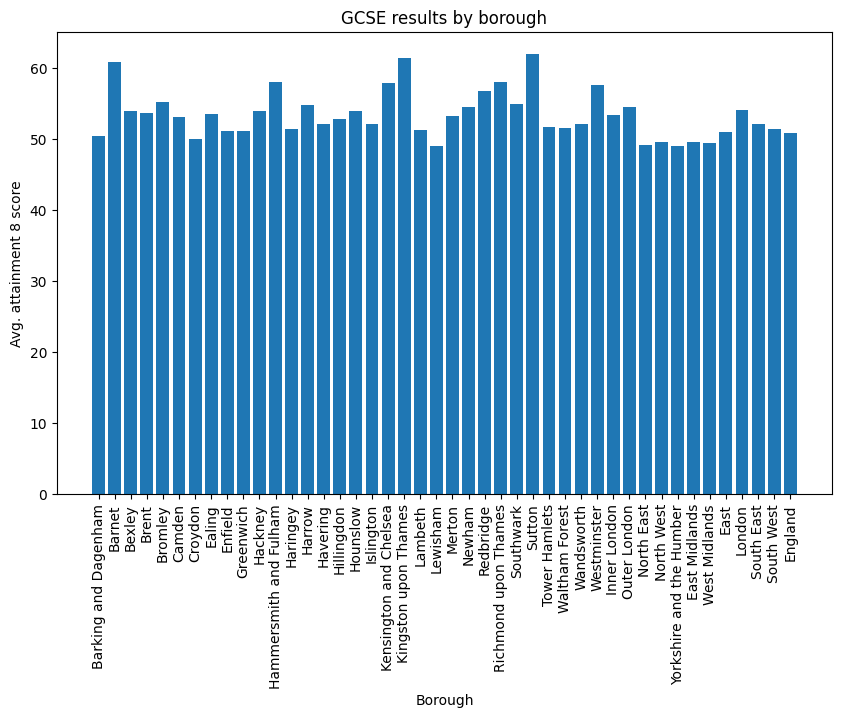

In [126]:
# bar chart
plt.figure(figsize=(10, 6))
plt.bar(gcses_by_borough['Area'], gcses_by_borough['Average Attainment 8 score per pupil'])

plt.title('GCSE results by borough')
plt.xlabel('Borough')
plt.ylabel('Avg. attainment 8 score')
plt.xticks(rotation=90)

plt.show()

## <div class="title_h2">Trees</div>

### <div class="title_h3">Data overview</div>

Available variables:
| variable         | description |
| --------------------------- | ------------|
| `objectid`                  | record identifier. |
| `borough`                   | The borough of London in which the tree resides. |
| `maintainer`                | The entity responsible for maintenance of the tree. |
| `gla_tree_name`             | The display name used for navigating the Greater London Authority tree map. |
| `tree_name`                 | Unsure. This appears to be an uncleaned version of gla_tree_name. |
| `taxon_name`                | Botanical name. This is the most specific identifier of the "same" tree across records. |
| `common_name`               | Common name. |
| `age`                       | This variable is messy and not reliable. See age_group below. |
| `age_group`                 | This classifies each tree as being in a specific age range. Options are: 'Young (0-15)', 'Early mature (16-30)', 'Mature (31-80)', 'Over mature (81-150)', and 'Veteran (over 150)'. Some are undefined. |
| `heigh_m`                   | Height in meters. This variable is sparsely populated and inconsistent in format. |
| `spread_m`                  | Canopy spread in meters. This variable is sparsely populated. |
| `canopy_spread_group`       | This classifies each tree as being in a specific range of canopy spread (in meters). Options are: '00 to 05m', '05 to 10m', '10 to 15m', and '15 to 20m'. Some are undefined. |
| `diameter_at_breast_height` | Diameter at breast height in meters. This variable is sparsely populated. |
| `dbh_group`                 | This classifies each tree as being in a specific range of diameter at breast height (in meters). Options are: '21 to 40cm', '41 to 70cm', '11 to 20cm', 'Upto 10cm', and '70cm+'. This variable is sparsely populated. |
| `longitude`                 | The longitudinal location of the tree. |
| `latitude`                  | The latitudinal location of the tree. |
| `condition`                 | The condition of the tree. Options are: 'Reasonable', 'Good', 'Poor', and 'Dead'. Data only available for Kingston Upon Thames |
| `load_data`                 | The date the tree was first recorded. |
| `updated`                   | The date the tree was last updated. |

### <div class="title_h3">Loading and cleaning the data</div>

In [127]:
# load the data
trees_data_file = './data/Borough_tree_list_2021July.csv'
trees_raw = pd.read_csv(trees_data_file)

# remove records that are not identified as species (this includes tree stumps, for example)
trees_data = trees_raw[~trees_raw['taxon_name'].str.lower().str.startswith('zz', na=True)].sort_values('taxon_name')

# remove 'Out' from boroughs
trees_data = trees_data[trees_data['borough'] != 'Out']

trees_data.head(5)

,objectid,borough,maintainer,gla_tree_name,tree_name,taxon_name,common_name,age,age_group,height_m,spread_m,canopy_spread_group,diameter_at_breast_height_cm,dbh_group,longitude,latitude,condition,load_date,updated
549678,549679,Lewisham,LB Lewisham,Pine,Pine,Abies,Fir,1 young,Young (0-15),NaN,NaN,NaN,NaN,NaN,0.000761,51.461473,NaN,20200928,20210715
549676,549677,Lewisham,LB Lewisham,Pine,Pine,Abies,Fir,1 mature,Mature (31-80),NaN,NaN,NaN,NaN,NaN,-0.013610,51.470342,NaN,20200928,20210715
549677,549678,Lewisham,LB Lewisham,Pine,Pine,Abies,Fir,1 mature,Mature (31-80),NaN,NaN,NaN,NaN,NaN,-0.013580,51.470368,NaN,20200928,20210715
549679,549680,Lewisham,LB Lewisham,Pine,Pine,Abies,Fir,1 mature,Mature (31-80),NaN,NaN,NaN,NaN,NaN,-0.031632,51.457732,NaN,20200928,20210715
549680,549681,Lewisham,LB Lewisham,Pine,Pine,Abies,Fir,1 mature,Mature (31-80),NaN,NaN,NaN,NaN,NaN,-0.032205,51.457814,NaN,20200928,20210715


### <div class="title_h3">Exploratory analysis</div>

In [128]:
trees_data.describe()

,objectid,spread_m,diameter_at_breast_height_cm,longitude,latitude,load_date,updated
count,762394.000000,100372.000000,208115.000000,762394.000000,762394.000000,7.623940e+05,762394.0
mean,405499.762893,5.406437,28.210981,-0.118732,51.515094,2.018907e+07,20210715.0
std,236376.677611,3.386238,29.892352,0.153487,0.083844,1.057118e+04,0.0
min,1.000000,0.100000,1.000000,-0.497710,51.301373,2.018021e+07,20210715.0
25%,194578.250000,3.000000,10.000000,-0.231540,51.453939,2.018021e+07,20210715.0
50%,421213.500000,5.000000,21.000000,-0.092263,51.513677,2.018021e+07,20210715.0
75%,611817.750000,7.000000,37.000000,0.000884,51.582418,2.020093e+07,20210715.0
max,817150.000000,29.000000,850.000000,0.286538,51.684488,2.021032e+07,20210715.0


In [129]:
# group by borough
trees_by_borough = trees_data.groupby('borough', as_index=False).size()
trees_by_borough.head(50)

,borough,size
0,Barking and Dagenham,19923
1,Barnet,29723
2,Bexley,11699
3,Brent,261
4,Bromley,65256
5,Camden,24181
6,City,1544
7,Croydon,954
8,Ealing,41481
9,Enfield,76179


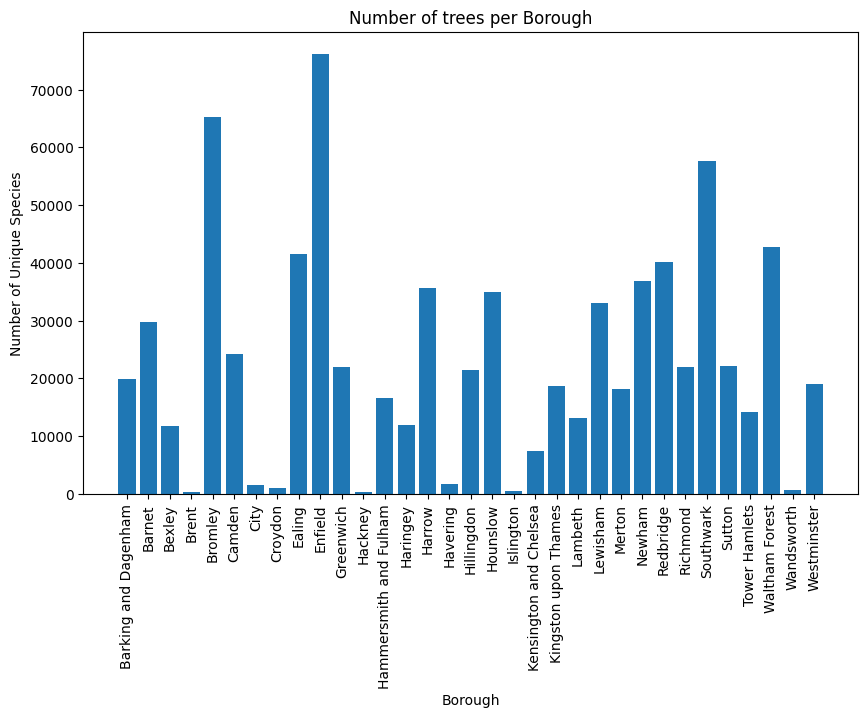

In [130]:
# bar chart
plt.figure(figsize=(10, 6))
plt.bar(trees_by_borough['borough'], trees_by_borough['size'])

plt.title('Number of trees per Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Unique Species')
plt.xticks(rotation=90)

plt.show()

## <div class="title_h2">Combining the data</div>
We need a common reference to connect the data sets. Since the data are from the same source, we are fortunate to be able to rely on borough name (mostly). We do have a little cleaning to do though.

In [131]:

# we have some mismatched and a group by artefact to sort out...
borough_sizes.rename(columns={'Name': 'borough', 'Square_Kilometres': 'sqkm'}, inplace=True)

gcses_by_borough.rename(columns={'Area': 'borough', 'Average Attainment 8 score per pupil': 'gcses'}, inplace=True)

trees_by_borough.rename(columns={'size': 'trees'}, inplace=True)
trees_by_borough.loc[trees_by_borough['borough'] == 'Richmond', 'borough'] = 'Richmond upon Thames'

# let's make a new dataframe to consolidate borough size, gcse results and tree counts
merged = pd.merge(trees_by_borough, gcses_by_borough, on='borough', how='left')
merged = pd.merge(merged, borough_sizes, on='borough', how='left')

# we don't have good data for London City so let's remove that
merged = merged[merged['borough'] != 'City']

merged.head(100)

,borough,trees,Code,gcses,sqkm
0,Barking and Dagenham,19923,E09000002,50.5,36.1
1,Barnet,29723,E09000003,60.8,86.7
2,Bexley,11699,E09000004,54.0,60.6
3,Brent,261,E09000005,53.7,43.2
4,Bromley,65256,E09000006,55.2,150.1
5,Camden,24181,E09000007,53.1,21.8
7,Croydon,954,E09000008,50.0,86.5
8,Ealing,41481,E09000009,53.6,55.5
9,Enfield,76179,E09000010,51.1,80.8
10,Greenwich,21941,E09000011,51.2,47.3


Okay let's make tree count relative to area...

In [132]:
merged['tree_density'] = merged['trees'] / merged['sqkm']

merged.head(100)

,borough,trees,Code,gcses,sqkm,tree_density
0,Barking and Dagenham,19923,E09000002,50.5,36.1,551.883657
1,Barnet,29723,E09000003,60.8,86.7,342.825836
2,Bexley,11699,E09000004,54.0,60.6,193.052805
3,Brent,261,E09000005,53.7,43.2,6.041667
4,Bromley,65256,E09000006,55.2,150.1,434.750167
5,Camden,24181,E09000007,53.1,21.8,1109.220183
7,Croydon,954,E09000008,50.0,86.5,11.028902
8,Ealing,41481,E09000009,53.6,55.5,747.405405
9,Enfield,76179,E09000010,51.1,80.8,942.809406
10,Greenwich,21941,E09000011,51.2,47.3,463.868922


Let's look at this...

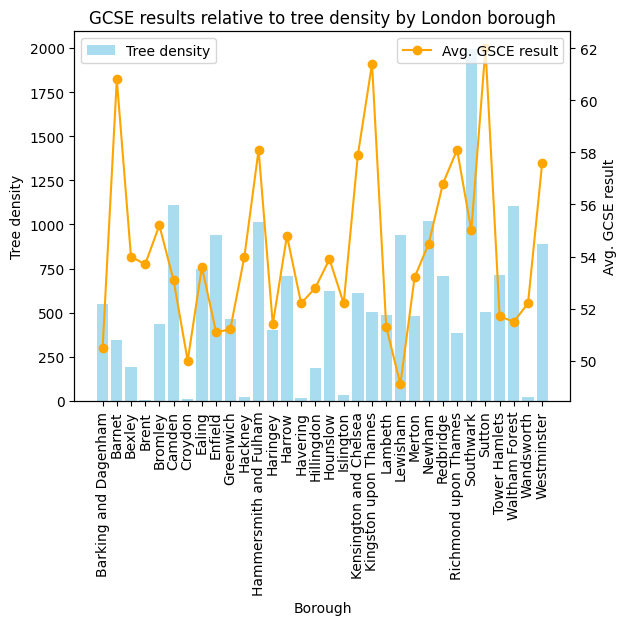

In [133]:
fig, tree_density_axis = plt.subplots()
plt.xticks(rotation=90)

tree_density_axis.bar(merged['borough'], merged['tree_density'], color='skyblue', label='Tree density', alpha=0.7)
tree_density_axis.set_xlabel('Borough')
tree_density_axis.set_ylabel('Tree density')
tree_density_axis.set_title('GCSE results relative to tree density by London borough')


gcse_axis = tree_density_axis.twinx()
gcse_axis.plot(merged['borough'], merged['gcses'], color='orange', marker='o', label='Avg. GSCE result')
gcse_axis.set_ylabel('Avg. GCSE result')

tree_density_axis.legend(loc='upper left')
gcse_axis.legend(loc='upper right')


plt.show()